# [로지스틱회귀모델 실습 : 모델링, 해석, 예측 성능 확인]

## Jupyter notebook 간단 사용법
- 위에 셀 추가 : 셀 왼쪽 부분 클릭 후, 키보드 'a'키 
- 아래에 셀 추가 : 셀 왼쪽 부분 클릭 후, 키보드 'b'키
- 셀 삭제 : 셀 왼쪽 부분 클릭 후, 키보드 'd'키 두번
- 셀 유형 변경: 코드 모드 (esc + y), 마크 다운 모드 (esc + m)
- 특정 셀 실행 : ctrl + enter
- 주석 처리 : 원하는 코드 드래그 후 , ctrl + /
- 주석 입력 : #주석 기입 or '''주석기입'''
- 쥬피터 노트북 저장 : ctrl + s

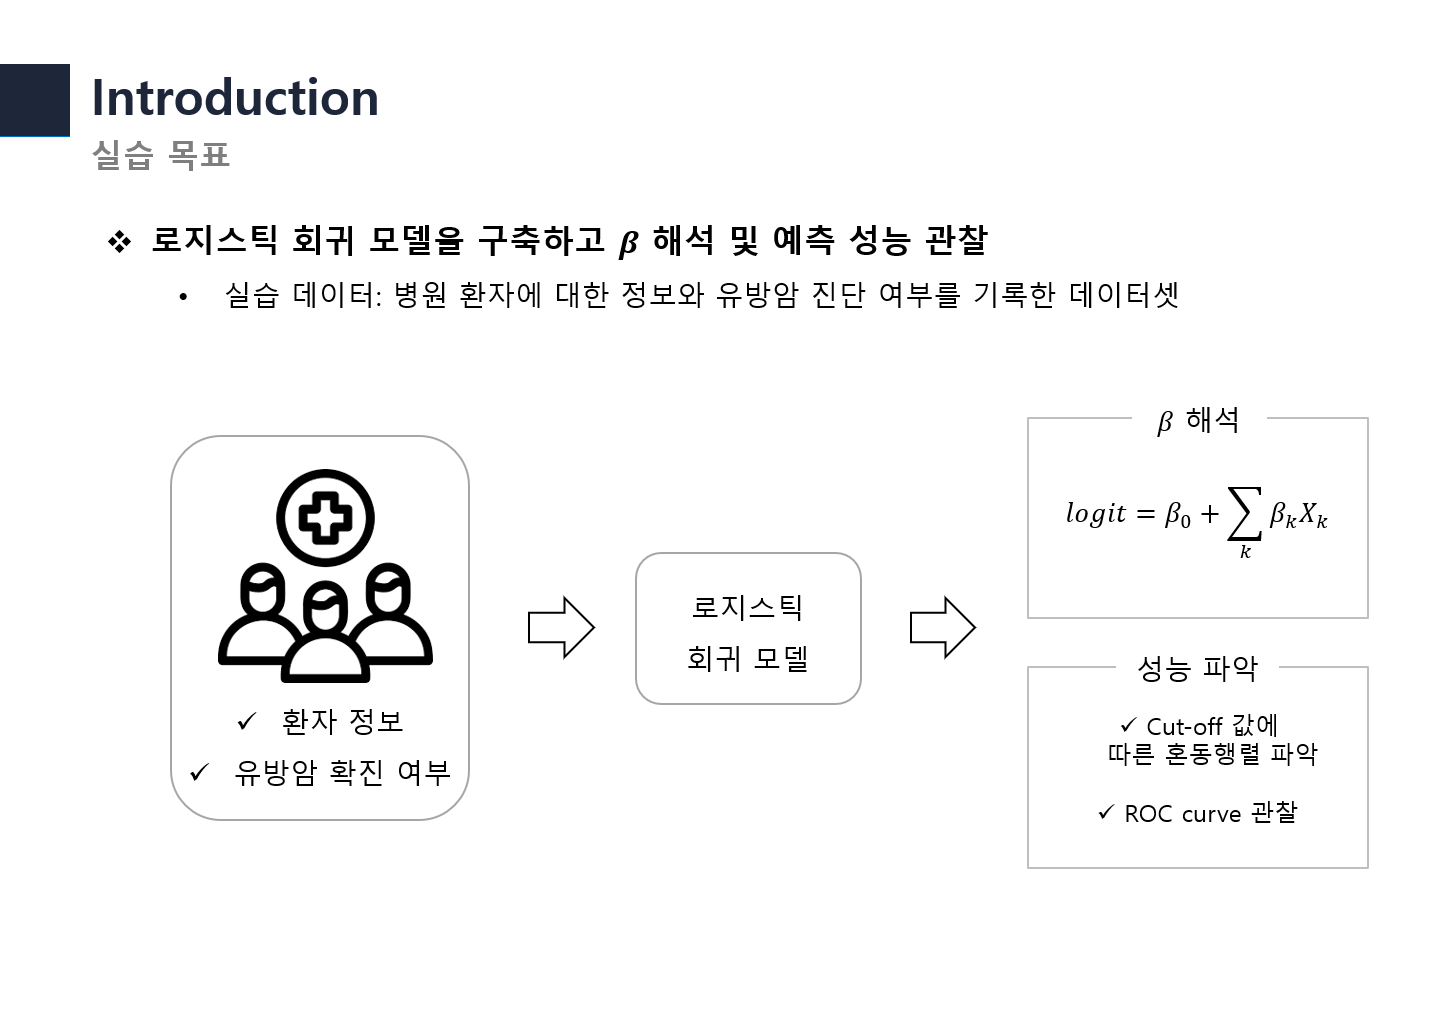

## 모듈 불러오기

- Numpy : https://numpy.org/  
- Pandas : https://pandas.pydata.org/  
- Matplotlib : https://matplotlib.org/  
- Scikit-learn : https://scikit-learn.org/stable/

In [ ]:
# 실습용 데이터 패키지
from sklearn.datasets import load_breast_cancer

# 데이터 전처리 패키지
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

# 기계학습 모델 구축 및 평가 패키지
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, accuracy_score, confusion_matrix, recall_score, precision_score

# 데이터 시각화 패키지
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 한글 폰트 설정
plt.rc('font', family='Malgun Gothic')

## 데이터 불러오기

In [ ]:
# 데이터셋 로드 및 설명 
breast_cancer = load_breast_cancer()
print(breast_cancer.DESCR)

### X변수 및 Y변수 확인

In [ ]:
print(breast_cancer.target_names) ## class {"0":'malignant',"1":"benign"}

In [ ]:
# 현재 데이터는 malignant = 0, benign = 1로 처리되어 있는 상황
breast_cancer.target

In [ ]:
# P(Y=1) : 유방암일 확률 , P(Y=0) : 유방암이 아닐 확률로 매칭하기 위해 malignant = 1, benign = 0으로 처리
breast_cancer.target = np.where(breast_cancer.target==0,1,0) ## np.where() 조건문

https://numpy.org/doc/stable/reference/generated/numpy.where.html

In [ ]:
breast_cancer.target

In [ ]:
print(type(breast_cancer.data), type(breast_cancer.target))

In [ ]:
# Data Shape 확인
print('input X shape=>',breast_cancer.data.shape)
print('target Y shape =>',breast_cancer.target.shape)

In [ ]:
malignant = breast_cancer.data[breast_cancer.target==1]
benign = breast_cancer.data[breast_cancer.target==0]

print('malignant(악성) =>',malignant.shape)
print('benign(양성) =>',benign.shape)

In [ ]:
for i,name in enumerate(breast_cancer.feature_names):
    print('%02d : %s' %(i+1,name))

### 변수별 target y 값 분포 확인

In [ ]:
plt.figure(figsize=[20,15])

for col in range(len(breast_cancer.feature_names)):
    plt.subplot(8,4,col+1) # 32개의 그래프 중 col번째 그래프 그리기
    plt.hist(malignant[:,col],bins=20, alpha=0.3) # 막대 너비 = 전체 구간을 bins=20으로 나누어 준 너비, alpha 는 투명도(0~1)를 조절
    plt.hist(benign[:,col], bins=20 ,alpha=0.3)
    plt.title(breast_cancer.feature_names[col])
    plt.legend(breast_cancer.target_names)
    plt.tight_layout()
#     plt.xticks([])

## 데이터 전처리하기

In [ ]:
# Train set/ Test set 나누기
X_train, X_test, y_train, y_test = train_test_split(breast_cancer.data,
                                                   breast_cancer.target,
                                                   test_size=0.3,
                                                   random_state=2021)
# 데이터 컬럼 단위 정규화 하기
normalizer = StandardScaler() 
X_train = normalizer.fit_transform(X_train)
X_test = normalizer.transform(X_test)

## 로지스틱 회귀 모델 구축하기

### 모델 학습하기

In [ ]:
# model 불러오기
model = LogisticRegression()

# model 학습시키기
model.fit(X_train, y_train)

### $\beta$ 확인하기

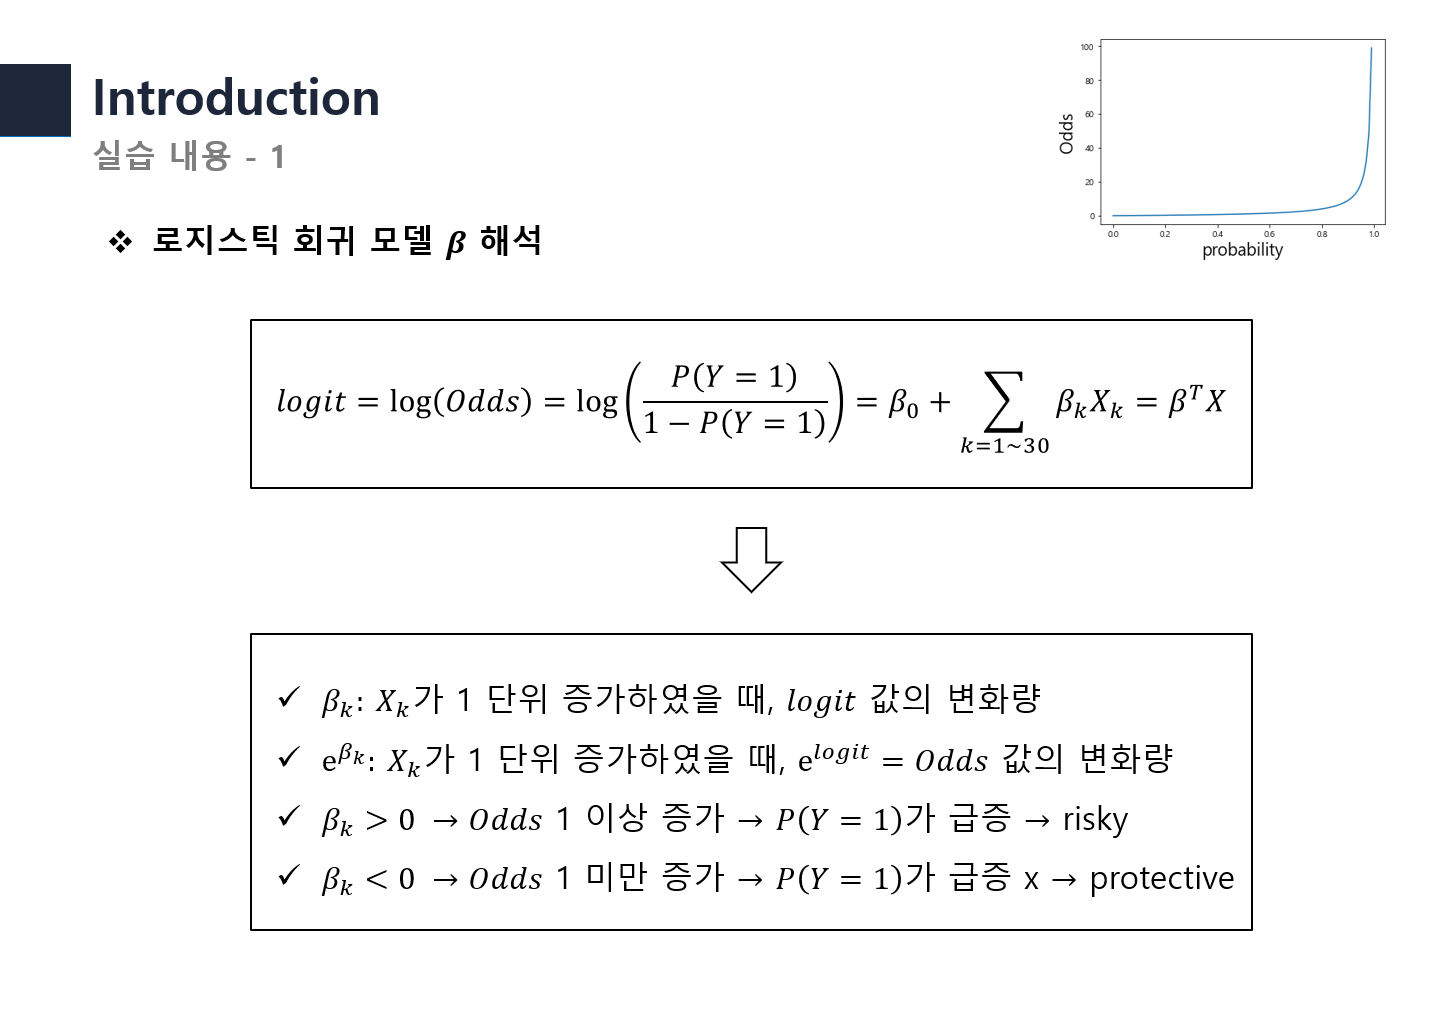

In [ ]:
# 데이터 컬럼에 따른 beta, exp(beta) 체크
column_name = ["const"] + breast_cancer.feature_names.tolist()
beta = np.concatenate([model.intercept_,model.coef_.reshape(-1)]).round(2) # round(2) 소수점 둘째짜리까지 반올림
odds = np.exp(beta).round(2) # round(2) 소수점 둘째짜리까지 반올림
interpret = np.where(beta>0,'risky','protective') # np.where() 조건문 

# beta 해석 정리
beta_analysis = pd.DataFrame(np.c_[beta,odds,interpret],index=column_name,columns=['beta','exp(beta)','interpret'])
beta_analysis

### Test data 예측하기

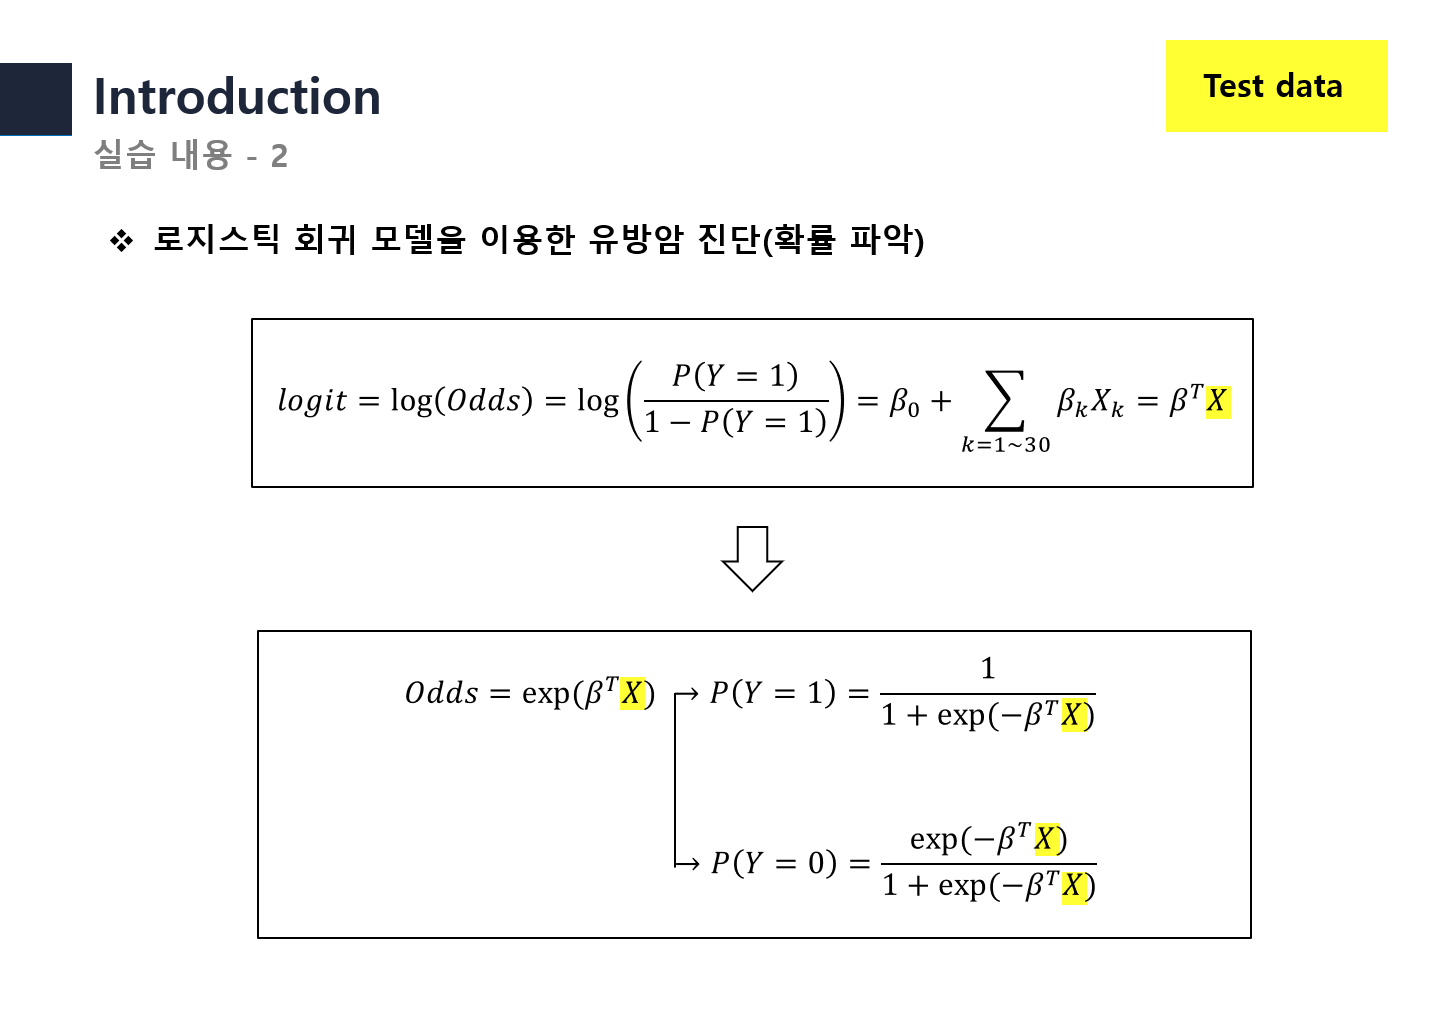

In [ ]:
# X_test에 대한 P(Y=0) 예측 확률값과 P(Y=1) 예측 확률값 - 패키지 이용
model.predict_proba(X_test)

In [ ]:
# X_test에 대한 P(Y=0) 예측 확률값과 P(Y=1) 예측 확률값 - 직접 계산

## beta 곱하기 X 계산 (np.c_ :상수항 파트)
Xbeta = np.matmul(np.c_[np.ones(X_test.shape[0]),X_test],beta.reshape(-1,1))
## P(Y=1) 계산
P_1 = 1 / (1+np.exp(-Xbeta))

## 패키지와 직접 계산 결과 비교
pd.DataFrame(np.concatenate([P_1,model.predict_proba(X_test)[:,1].reshape(-1,1)],axis=1),columns=['직접','패키지'])

### 성능 평가하기

#### Cut off 값을 변화하면서 Accuracy 성능 관찰

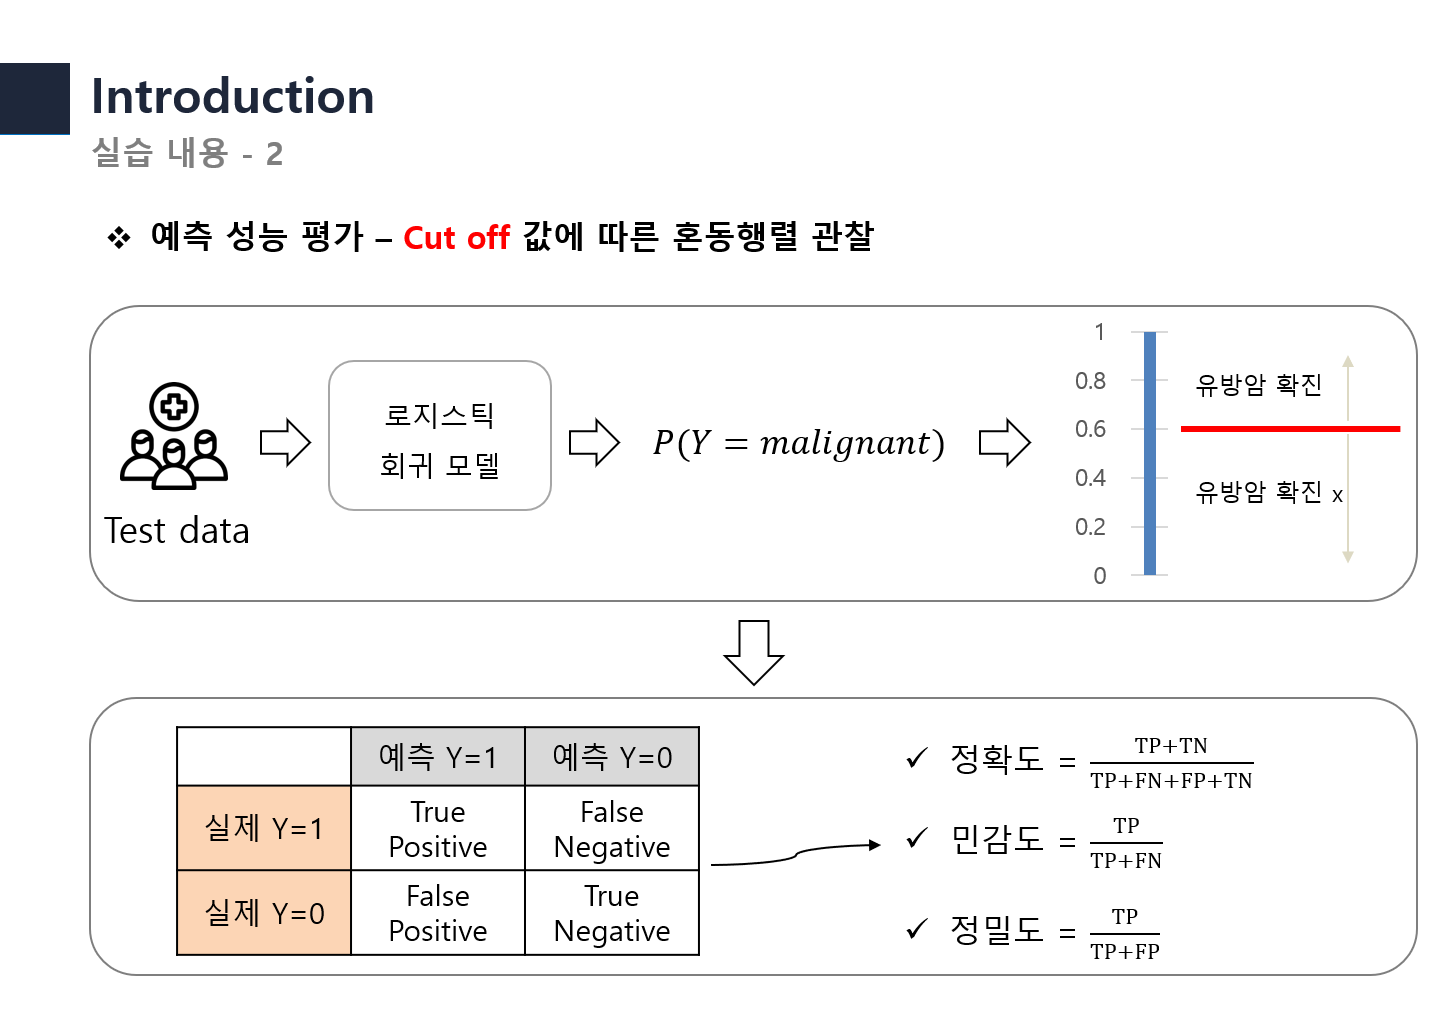

In [ ]:
# Cut off 값을 변화하면서 Accuracy 성능 관찰
probs = model.predict_proba(X_test)[:, 1] ## [:,1]은 두번째 컬럼을 indexing 한다는 뜻

Cut_off = np.linspace(0,1,11)
for cutoff in Cut_off:
    y_pred = np.where(P_1.reshape(-1)>=cutoff,1,0) # 확률값이 cuf off보다 크면 1(유방암), 아니면 0(유방암x)
    acc = accuracy_score(y_true = y_test, y_pred =y_pred) ## 정확도
    recall = recall_score(y_true = y_test, y_pred =y_pred) ## 민감도
    precision = precision_score(y_true = y_test, y_pred =y_pred) ## 정밀도
    
    print(f"정확도:{acc:0.2f}",f"민감도:{recall:0.2f}",f"정밀도:{precision:0.2f}",f"cut off:{cutoff:0.2f}", sep='  |  ')  

#### Roc curve 그리기

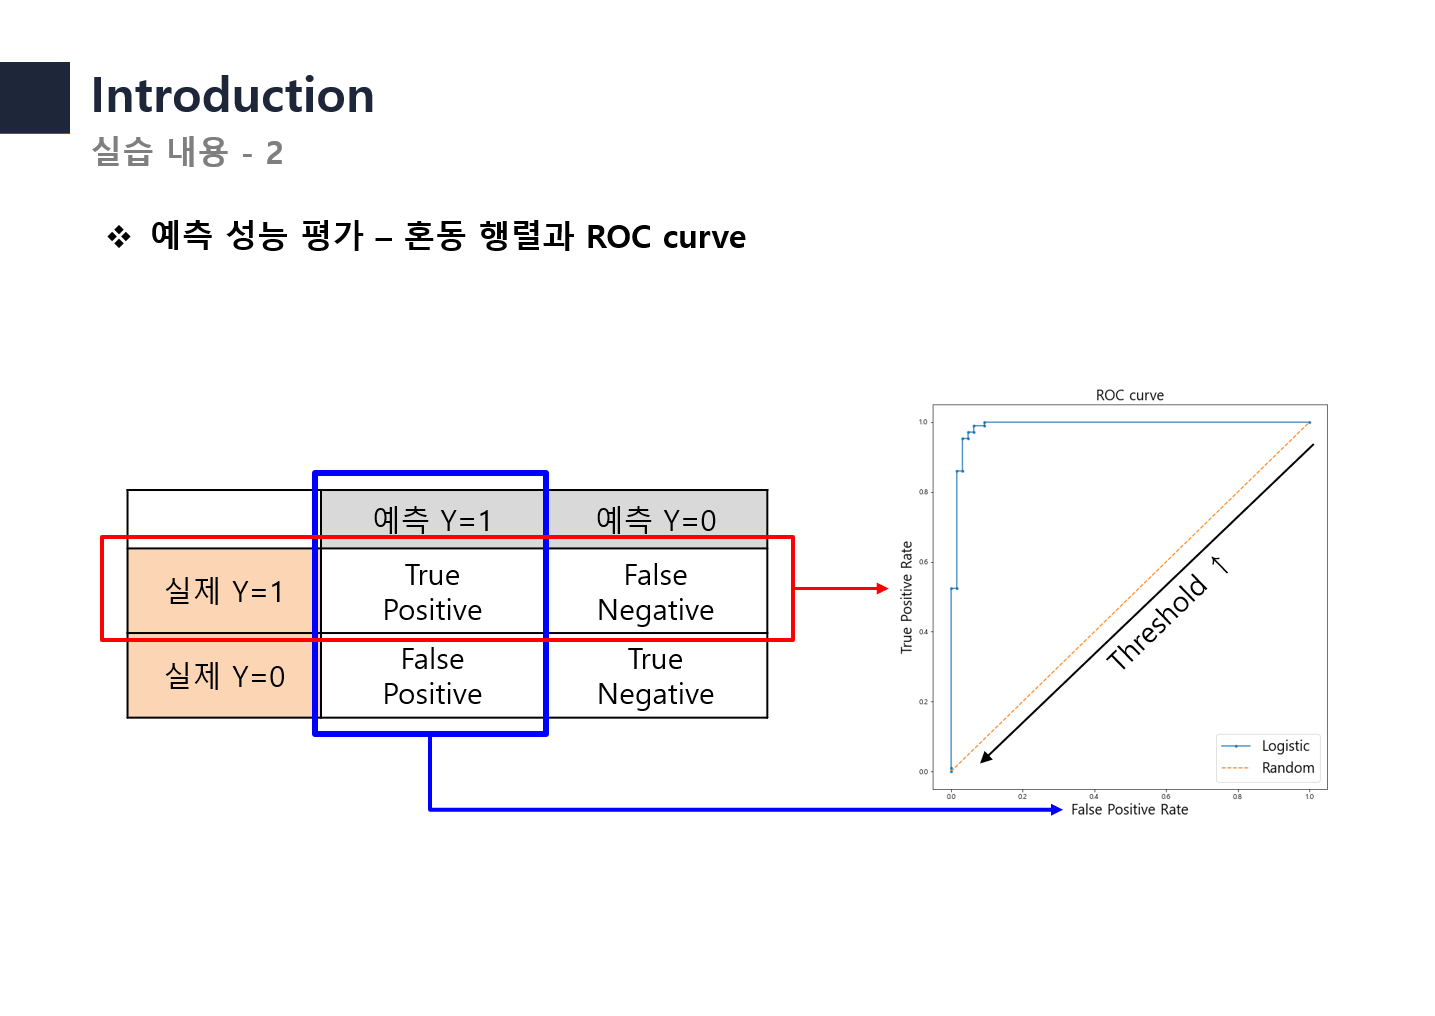

In [ ]:
# Roc curve X 축, Y축 추출
model_fpr, model_tpr, threshold1 = roc_curve(y_test, probs)
random_fpr, random_tpr, threshold2 = roc_curve(y_test, [0 for i in range(X_test.__len__())])

# plot the roc curve for the model and random
plt.figure(figsize=(10,10))
plt.plot(model_fpr, model_tpr, marker='.', label='Logistic')
plt.plot(random_fpr, random_tpr, linestyle='--', label='Random')

# axis labels
plt.xlabel('False Positive Rate',size=20)
plt.ylabel('True Positive Rate',size=20)
 
# show the legend
plt.legend(fontsize=20)
 
# show the plot
plt.title("ROC curve",size=20)
plt.show()

# EOD